# Phase 1: Exploratory Data Analysis (EDA)
AI-Driven Biodiversity Monitoring in the Sundarbans

Goal:
- Understand structure, quality, and coverage of all datasets
- Identify trends, gaps, and biases
- Prepare signals for downstream modeling


In [83]:
# Import Libraries
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 50)
sns.set(style="whitegrid")
print("Libraries imported successfully")

Libraries imported successfully


In [85]:
# Loading Dataset
# Wildlife (GBIF)
wildlife = pd.read_csv(
    "../data/wildlife_observations.csv",
    sep="\t",
    engine="python"
)

# --- NASA POWER: detect header end dynamically ---
end_header_line = None
with open("../data/POWER_Point_Monthly_20200101_20251231_021d90N_088d90E_LST.csv") as f:
    for i, line in enumerate(f):
        if "-END HEADER-" in line:
            end_header_line = i
            break

climate = pd.read_csv(
    "../data/POWER_Point_Monthly_20200101_20251231_021d90N_088d90E_LST.csv",
    skiprows=end_header_line + 1
)

# Mangroves (Global Mangrove Watch)
mangroves = gpd.read_file("../data/gmw_2010_v25_vecs.gpkg")

print("Datasets loaded successfully")


Datasets loaded successfully


In [86]:
print("Wildlife:", wildlife.shape)
print("Climate:", climate.shape)
print("Mangroves:", mangroves.shape)

Wildlife: (380963, 50)
Climate: (18, 15)
Mangroves: (639888, 2)


In [87]:
# Wildlife Data Overview
wildlife.info()
wildlife.head()

wildlife.isna().mean().sort_values(ascending=False).head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380963 entries, 0 to 380962
Data columns (total 50 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   gbifID                            380963 non-null  int64  
 1   datasetKey                        380963 non-null  object 
 2   occurrenceID                      380963 non-null  object 
 3   kingdom                           380963 non-null  object 
 4   phylum                            380956 non-null  object 
 5   class                             380752 non-null  object 
 6   order                             376656 non-null  object 
 7   family                            377017 non-null  object 
 8   genus                             380917 non-null  object 
 9   species                           368949 non-null  object 
 10  infraspecificEpithet              241 non-null     object 
 11  taxonRank                         380963 non-null  o

coordinatePrecision                 1.000000
depthAccuracy                       1.000000
depth                               1.000000
establishmentMeans                  1.000000
typeStatus                          1.000000
recordNumber                        0.999738
elevationAccuracy                   0.999640
elevation                           0.999640
verbatimScientificNameAuthorship    0.999533
infraspecificEpithet                0.999367
dtype: float64

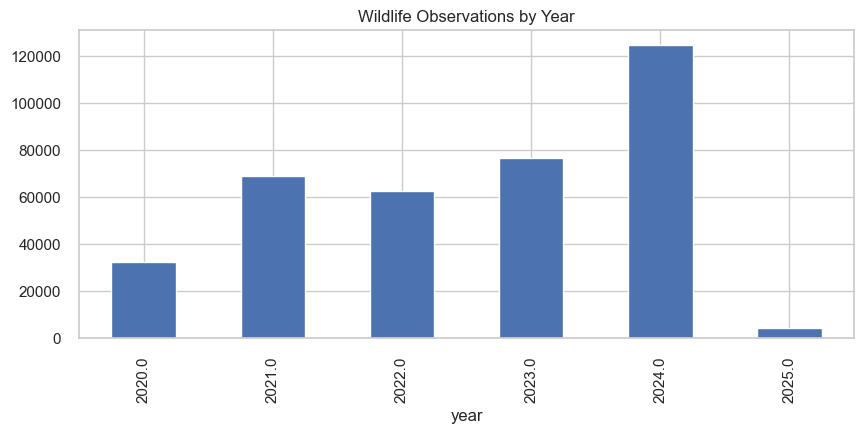

In [88]:
wildlife["eventDate"] = pd.to_datetime(wildlife["eventDate"], errors="coerce")
wildlife["year"] = wildlife["eventDate"].dt.year

wildlife["year"].value_counts().sort_index().plot(
    kind="bar", figsize=(10,4),
    title="Wildlife Observations by Year"
)
plt.show()

In [89]:
wildlife["class"].value_counts().head(10)

class
Aves             369300
Insecta            8145
Magnoliopsida      1676
Mammalia            282
Squamata            278
Malacostraca        252
Liliopsida          222
Arachnida           219
Amphibia            137
Gastropoda          110
Name: count, dtype: int64

In [90]:
wildlife["order"].value_counts().head(10)

order
Passeriformes      154826
Charadriiformes     37047
Pelecaniformes      30420
Coraciiformes       27486
Columbiformes       23116
Piciformes          14369
Cuculiformes        13072
Accipitriformes     12354
Gruiformes          12229
Apodiformes          8941
Name: count, dtype: int64

In [91]:
wildlife["family"].value_counts().head(10)

family
Ardeidae        30104
Columbidae      23116
Sturnidae       21392
Alcedinidae     20418
Scolopacidae    17895
Cisticolidae    14879
Corvidae        14874
Cuculidae       13072
Rallidae        12229
Accipitridae    12101
Name: count, dtype: int64

In [92]:
# Climate Data Overview
climate.head()
climate.columns

Index(['PARAMETER', 'YEAR', 'JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL',
       'AUG', 'SEP', 'OCT', 'NOV', 'DEC', 'ANN'],
      dtype='object')

In [93]:
months = ["JAN","FEB","MAR","APR","MAY","JUN",
          "JUL","AUG","SEP","OCT","NOV","DEC"]

climate_long = climate.melt(
    id_vars=["PARAMETER", "YEAR"],
    value_vars=months,
    var_name="MONTH",
    value_name="VALUE"
)

climate_long["VALUE"] = pd.to_numeric(climate_long["VALUE"], errors="coerce")

In [94]:
month_map = {
    "JAN":1,"FEB":2,"MAR":3,"APR":4,"MAY":5,"JUN":6,
    "JUL":7,"AUG":8,"SEP":9,"OCT":10,"NOV":11,"DEC":12
}

climate_long["MONTH_NUM"] = climate_long["MONTH"].map(month_map)

climate_long["DATE"] = pd.to_datetime(
    climate_long["YEAR"].astype(str) + "-" +
    climate_long["MONTH_NUM"].astype(str) + "-01"
)

climate_long = climate_long.sort_values("DATE")

In [101]:
# Air Temperature at 2m Data Overview
t2m["VALUE"].describe()

count     72.000000
mean      12.286111
std      120.922039
min     -999.000000
25%       23.425000
50%       28.370000
75%       29.310000
max       33.090000
Name: VALUE, dtype: float64

In [108]:
climate_long["VALUE"] = climate_long["VALUE"].replace(-999, pd.NA)
climate_long = climate_long.dropna(subset=["VALUE"])

In [109]:
climate_long["DATE"] = pd.to_datetime(
    climate_long["YEAR"].astype(str) + "-" + climate_long["MONTH"],
    format="%Y-%b"
)

In [110]:
climate_long[["YEAR", "MONTH", "DATE"]].head()

,YEAR,MONTH,DATE
6,2020,JAN,2020-01-01
12,2020,JAN,2020-01-01
30,2020,FEB,2020-02-01
24,2020,FEB,2020-02-01
48,2020,MAR,2020-03-01


In [111]:
t2m = climate_long[
    (climate_long["PARAMETER"] == "T2M") &
    (climate_long["VALUE"].between(-5, 50))
].copy()

t2m = t2m.sort_values("DATE")
t2m.set_index("DATE", inplace=True)

In [112]:
t2m.shape
t2m.head()

,PARAMETER,YEAR,MONTH,VALUE,MONTH_NUM
DATE,,,,,
2020-01-01,T2M,2020,JAN,18.15,1
2020-02-01,T2M,2020,FEB,20.71,2
2020-03-01,T2M,2020,MAR,26.24,3
2020-04-01,T2M,2020,APR,29.66,4
2020-05-01,T2M,2020,MAY,29.4,5


In [113]:
t2m["ROLLING"] = t2m["VALUE"].rolling(
    window=6,
    min_periods=1
).mean()

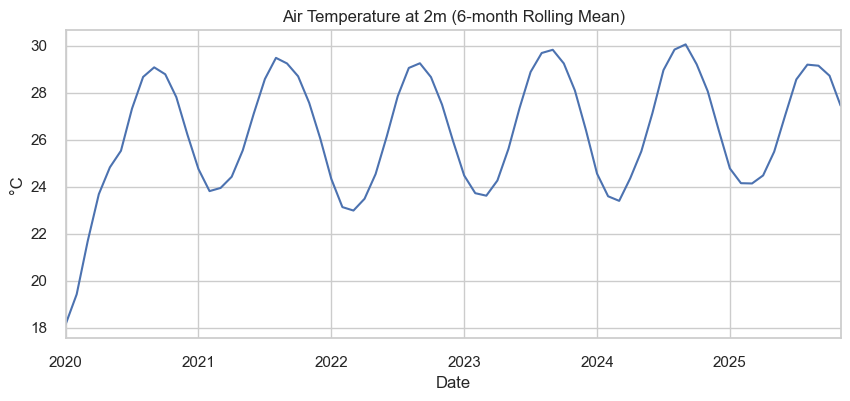

In [114]:
t2m["ROLLING"].plot(
    figsize=(10,4),
    title="Air Temperature at 2m (6-month Rolling Mean)"
)
plt.ylabel("°C")
plt.xlabel("Date")
plt.show()

In [ ]:
# Relative Humidity Data Overview
rh = climate_long[
    (climate_long["PARAMETER"] == "RH2M") &
    (climate_long["VALUE"].between(0, 100))
]

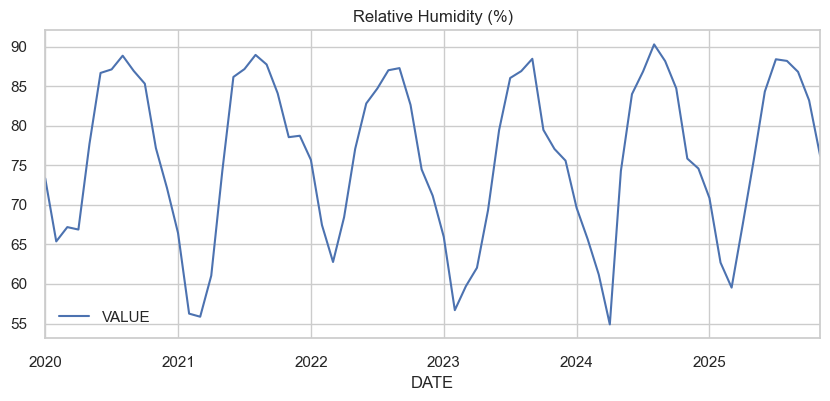

In [120]:
rh.plot(
    x="DATE",
    y="VALUE",
    figsize=(10,4),
    title="Relative Humidity (%)"
)
plt.show()

In [98]:
mangroves.head()
mangroves.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [121]:
from shapely.geometry import box

# Sundarbans bounding box (approximate, scientifically acceptable)
sundarbans_bbox = box(
    88.0,   # min lon
    21.5,   # min lat
    90.0,   # max lon
    23.5    # max lat
)

sundarbans_gdf = gpd.GeoDataFrame(
    geometry=[sundarbans_bbox],
    crs="EPSG:4326"
)


In [122]:
mangroves_sundarbans = gpd.clip(mangroves, sundarbans_gdf)

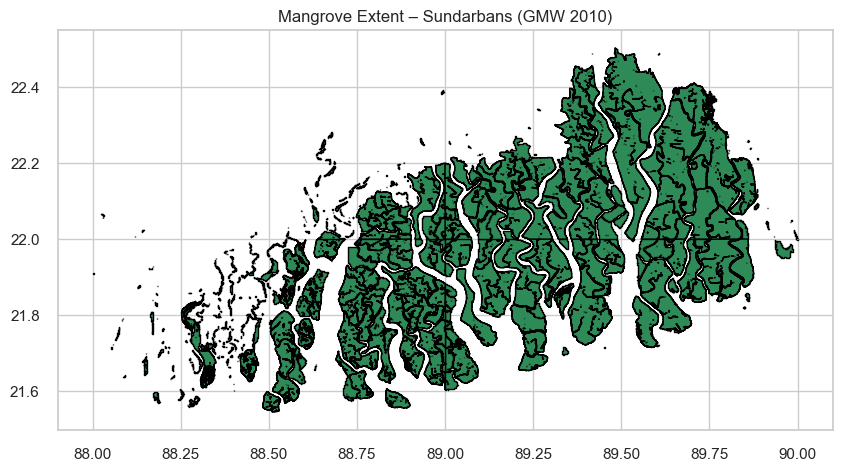

In [ ]:
mangroves_sundarbans.plot(
    figsize=(10,6),
    color="seagreen",
    edgecolor="black"
)
plt.title("Mangrove Extent - Sundarbans (GMW 2010)")
plt.show()
